## Pitfall #3: Feature selection outside cross-validation

In this notebook we will demonstrate a pitfall that you will encounter when you process your data outside of a cross-validation step. These processing steps generally involve transformations to your data, such as feature selection steps or projections, before you split the data into a training and a test set. As we'll see later, processing before splitting can result in information leaking into the training set from the test set and have severe downstream consequences.

In [1]:
%pylab inline
import seaborn; seaborn.set_style('whitegrid')
import pandas

from tqdm import tqdm

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

Populating the interactive namespace from numpy and matplotlib


Although this issue is general to any data set, we will demonstrate it here entirely with random data. Using entirely random data is a good choice because we know that there should be no signal or predictive power in any of the features and so any performance significantly above random is a warning that something is wrong. Further, when we construct our data set to not have any underlying structure, we remove any possibility that the structure is the reason for the problem. The results we see here are applicable, in varying degrees, to any data set.

More specifically, we can generate our data set to be entirely Gaussian random values drawn independently and our label vector to be random binary values. For the purpose of demonstrating this pitfall we will generate a data set that has many more features than examples to mimic biological data sets such as gene expression or methylation arrays. 

In [2]:
numpy.random.seed(0)

X_rand = numpy.random.randn(500, 10000)
y = numpy.random.randint(2, size=500)

The easiest preprocessing step to demonstrate this pitfall is using supervised feature selection. This method attempts to remove irrelevant features by calculating the predictive power of each feature individually and discarding those with the lowest power. This can be done by calculating the correlation of each feature with the labels or some form of rank-based metric like AUROC/average precision. We will use the ANOVA F-value, which is the default in sklearn, to prune the number of features down.

In [3]:
from sklearn.feature_selection import SelectKBest

X_ = SelectKBest(k=200).fit_transform(X_rand, y)

Now, let's calculate the average performance of a logistic regression model in a 20-fold cross-validation using this reduced data set. Presumably, the performance should be random chance because, by construction, the entire data set is random.

In [4]:
from sklearn.model_selection import cross_val_score

cross_val_score(LogisticRegression(random_state=0), X_, y, cv=20, n_jobs=-1).mean()

0.908

That's weird! How do we get such good performance on a data set that's entirely random values? Do we need to regularize the model?

In [5]:
from sklearn.model_selection import cross_val_score

cross_val_score(LogisticRegressionCV(random_state=0), X_, y, cv=20, n_jobs=-1).mean()

0.9339999999999999

It looks like the issue may be even worse when regularization is used. Perhaps this is an oddity associated with linear models and we wouldn't see the same thing with a non-linear model?

In [6]:
cross_val_score(RandomForestClassifier(random_state=0), X_, y, cv=20, n_jobs=-1).mean()

0.7760000000000001

In [7]:
cross_val_score(SVC(kernel='rbf', random_state=0), X_, y, cv=20, n_jobs=-1).mean()

0.9280000000000002

In [8]:
cross_val_score(GradientBoostingClassifier(random_state=0), X_, y, cv=20, n_jobs=-1).mean()

0.682

It looks like all approaches achieve better-than-random performance despite the underlying data being randomly generated.

Does the number of features selected play a role? Here we set it to 200 but maybe that's an unlucky number.

In [9]:
scores = []
for k in 10 ** numpy.arange(0.5, 4.1, 0.1):
    X_k = SelectKBest(k=int(k)).fit_transform(X_rand, y)
    scores.append(cross_val_score(RandomForestClassifier(n_estimators=100), X_k, y, cv=20, n_jobs=-1).mean())

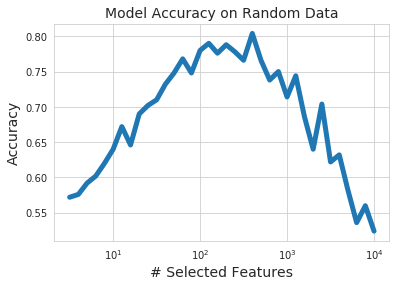

In [10]:
plt.figure(facecolor='w')
plt.title("Model Accuracy on Random Data", fontsize=14)
plt.plot(10 ** numpy.arange(0.5, 4.1, 0.1), scores, linewidth=5)
plt.xscale('log')
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("# Selected Features", fontsize=14)
plt.show()

To spoil the mystery, the problem is that when the top K features were selected they were selected *because they performed well across the entire data set, not just the training set*. Because all of our features and labels were random, this means that features that happened, by chance, to correlate with the labels across the entire data set were selected and those that did not were not selected. Because it's unlikely that any one feature correlates perfectly with the labels the model gains additional predictive power as additional features are added to a point, and then performance begins to degrade as a reversion to the mean.

You might be thinking, "well, if some features correlate well with the label, why wouldn't you use them?" The issue is that we know, *by construction*, that there is no connection between the feature and the labels. Any associations that we find in our data set are spurious and will not hold up in future examples. We can confirm that this process does not generalize to new data by performing the same evaluation except including the feature selection within the cross-validation.

In [11]:
from sklearn.pipeline import Pipeline

model = Pipeline([('select-k-best', SelectKBest(k=200)),
                  ('model', LogisticRegressionCV(random_state=0))])

cross_val_score(model, X_rand, y, cv=20, n_jobs=-1).mean()

0.556

Looks like the performance dropped from around 93% to around 50%. We can confirm that this is the case with a non-linear model as well.

In [12]:
from sklearn.pipeline import Pipeline

model = Pipeline([('select-k-best', SelectKBest(k=200)),
                  ('model', RandomForestClassifier(random_state=0))])

cross_val_score(model, X_rand, y, cv=20, n_jobs=-1).mean()

0.528

Looks like the same thing here.

Well, what if you aren't training a supervised machine learning model? What if you just want to make a projection of the data to see whether there are distinct clusters? Surely that should be okay, because you aren't making use of the labels after filtering features.

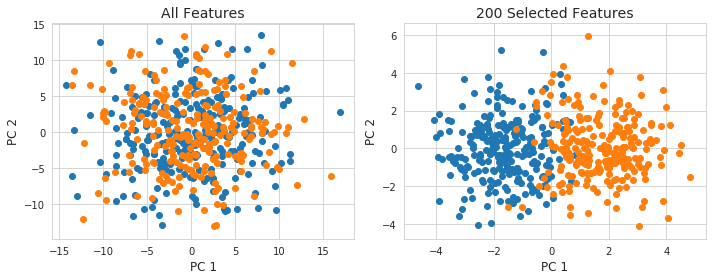

In [13]:
from sklearn.decomposition import PCA

pca1 = PCA(2).fit_transform(X_rand)
pca2 = PCA(2).fit_transform(X_)

plt.figure(figsize=(10, 4), facecolor='w')
plt.subplot(121)
plt.title("All Features", fontsize=14)
plt.scatter(*pca1[y == 0].T)
plt.scatter(*pca1[y == 1].T)
plt.xlabel("PC 1", fontsize=12)
plt.ylabel("PC 2", fontsize=12)

plt.subplot(122)
plt.title("200 Selected Features", fontsize=14)
plt.scatter(*pca2[y == 0].T)
plt.scatter(*pca2[y == 1].T)
plt.xlabel("PC 1", fontsize=12)
plt.ylabel("PC 2", fontsize=12)
plt.tight_layout()
plt.show()

When we perform PCA using all of our features and then color the points according to their label, we get to overlapping clusters, as we would expect because everything is random. However, when we perform PCA using only the top 200 selected features, it looks like there are two distinct clusters. This means that *even if you aren't training a supervised machine learning model, you can still get problematic results* because you biased the data by selecting features using the labels in the preprocessing step.